### Neural Networks

In [1]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping 

from constants import DATA_DIR
from utils import csv_concatenate, calculate_FPTS, calculate_MAE, calculate_RMSE, cross_val

Using TensorFlow backend.


In [38]:
np.random.seed(23)
warnings.filterwarnings("ignore")

In [31]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def create_model(model_num):
    def model_1():
        model = Sequential()
        model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))
        model.compile(loss=root_mean_squared_error, optimizer='adam')
        model.summary()
        return model

    def model_2():
        model = Sequential()
        model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=root_mean_squared_error, optimizer='adam')
        model.summary()
        return model

    def model_3():
        model = Sequential()
        model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=root_mean_squared_error, optimizer='adam')
        model.summary()
        return model
    
    if model_num == 1:
        return model_1()
    elif model_num == 2:
        return model_2()
    elif model_num == 3:
        return model_3()
    else:
        return "invalid model_num"

In [43]:
def load_trained_model(weights_path):
    model = create_model()
    model.load_weights(weights_path)
    return model

def get_weights_path(model_num):
    filepaths = glob.glob(DATA_DIR+"/Models/NN/Model_{}/*.hdf5".format(str(model_num)))
    losses = [float(filepath[-12:-5]) for filepath in filepaths]
    print(losses, len(losses))
    print('Lowest Valid Error: {} at Epoch {}'.format(min(losses), losses.index(min(losses))))
    return filepaths[losses.index(min(losses))]

In [45]:
df_features

,Date,Name,Team,Pos,FPTS,Salary,Starter,Rest,Rota_All,Rota_Pos,...,AST_perc,DRB_perc,ORB_perc,BLK_perc,TOV_perc,STL_perc,eFG_perc,FG_perc,3P_perc,FT_perc
0,20181104,Markelle Fultz,PHI,PG/SG,15.50,5300.0,1,1,7,2,...,26.437922,17.580519,5.330649,1.154286,10.565974,2.324675,0.369797,0.357758,0.114629,0.639449
1,20181104,Landry Shamet,PHI,PG,15.25,3100.0,0,1,7,2,...,5.708831,3.170130,0.224416,0.024935,6.065714,0.997662,0.619951,0.475706,0.410899,0.481818
2,20181104,J.J. Redick,PHI,SG/SF,18.25,5800.0,0,1,7,1,...,19.257922,7.176623,1.745195,0.420000,11.811169,0.514286,0.449003,0.332826,0.377922,0.770096
3,20181104,Dario Saric,PHI,SF/PF,17.25,5000.0,1,1,7,2,...,10.564416,14.644935,4.488831,0.128052,15.833247,0.317403,0.346306,0.284408,0.242055,0.608239
4,20181104,Robert Covington,PHI,SF/PF,11.25,6200.0,1,1,7,2,...,5.122078,14.565974,1.262857,4.135844,13.434286,3.271429,0.642686,0.492758,0.538481,0.290649
5,20181104,Joel Embiid,PHI,C,41.75,11800.0,1,1,7,2,...,16.926234,32.439481,7.403896,5.641039,10.812468,0.016883,0.523239,0.488335,0.342013,0.818062
6,20181104,Amir Johnson,PHI,PF/C,5.25,3200.0,0,1,7,2,...,22.042857,25.294286,7.772727,1.897403,21.676104,1.528052,0.431416,0.431416,0.000000,0.724026
7,20181105,Zach LaVine,CHI,PG/SG,60.00,8000.0,1,2,8,4,...,23.151688,17.126234,0.668831,0.868571,13.978182,1.493766,0.431745,0.383229,0.275426,0.898808
8,20181105,Antonio Blakeney,CHI,PG,24.25,3700.0,0,2,8,4,...,6.195065,15.424156,0.547273,0.461039,3.966753,0.022857,0.534405,0.433532,0.474327,0.682860
9,20181105,Cameron Payne,CHI,PG/SG,16.75,4100.0,1,2,8,4,...,24.587273,7.142338,3.116104,0.727013,16.408571,2.192208,0.365091,0.308865,0.226696,0.555844


In [50]:
def load_dataset(weighting):
    weighting = 'quad'
    df_features = csv_concatenate(os.path.join(DATA_DIR, 'Dataframes','Modelling', 'Features', weighting))

    X = df_features.loc[:, df_features.columns[5:]]
    X = MinMaxScaler().fit_transform(X)
    y = df_features['FPTS'].values.reshape(-1,1).flatten()

In [49]:
X, y = load_dataset(weighting)

NameError: name 'df' is not defined

In [56]:
es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

model = KerasRegressor(build_fn=model_1,
                       epochs=30,
                       batch_size=32,
                       validation_split=0.2,
                       shuffle=True,
                       verbose=1)
h1 = model.fit(X, y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_50 (Dense)             (None, 64)                2624      
_________________________________________________________________
dense_51 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 33        
Total params: 6,377
Trainable params: 6,377
Non-trainable params: 0
_________________________________________________________________
Train on 96004 samples, validate on 24001 samples
Epoch 1/30
96004/96004 [==============================] - 13s 139us/step - loss: 9.4555 - val_loss: 9.4209
Epoch 2/30
96004/96004 [==============================] - 10s 104us/step - loss: 9.1623 - val_loss: 9.3479
Epoch 3/

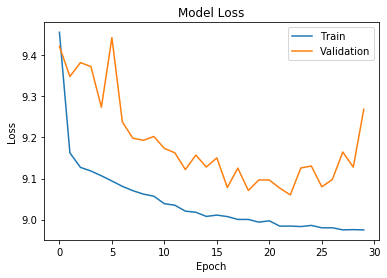

In [57]:
plt.plot(h1.history['loss'])  
plt.plot(h1.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation'], loc='upper right')  
plt.show()

In [59]:
model = KerasRegressor(build_fn=model_2,
                       epochs=60,
                       batch_size=32,
                       validation_split=0.2,
                       shuffle=True,
                       verbose=1)
h2 = model.fit(X, y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_59 (Dense)             (None, 64)                2624      
_________________________________________________________________
dense_60 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_61 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 33        
Total params: 16,745
Trainable params: 16,745
Non-trainable params: 0
_________________________________________________________________
Train 

In [ ]:
model = KerasRegressor(build_fn=model_3,
                       epochs=60,
                       batch_size=32,
                       validation_split=0.2,
                       shuffle=True,
                       verbose=1)
h3 = model.fit(X, y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_82 (Dense)             (None, 128)               5248      
_________________________________________________________________
dense_83 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_84 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 65        
Total params: 56,425
Trainable params: 56,425
Non-trainable params: 0
_________________________________________________________________
Train 

In [ ]:
for hist in [h1, h3]:
    plt.subplot(111)  
    plt.plot(hist.history['loss'])  
    plt.plot(hist.history['val_loss'])  
    plt.title('Model Loss')  
    plt.ylabel('Loss')  
    plt.xlabel('Epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')  
    plt.show()

In [ ]:
model = KerasRegressor(build_fn=model_1,
                       epochs=30,
                       batch_size=32,
                       validation_split=0.2,
                       shuffle=True,
                       verbose=1)

kfold = KFold(n_splits=5, shuffle=True)

In [ ]:
results_MAE = cross_val_score(model, X, y, cv=kfold, n_jobs=1, scoring='neg_mean_absolute_error')
results_RMSE = cross_val_score(model, X, y, cv=kfold, n_jobs=1, scoring='neg_mean_squared_error')

In [ ]:
print(np.sqrt(-results_RMSE))
print("Results: %.4f RMSE" % np.sqrt(np.mean(-results_RMSE)))

print(np.sqrt(-results_MAE))
print("Results: %.4f MAE" % np.mean(-results_MAE))

In [ ]:
model = KerasRegressor(build_fn=model_3,
                       epochs=15,
                       batch_size=32,
                       validation_split=0.2,
                       shuffle=True,
                       verbose=2)

kfold = KFold(n_splits=5, shuffle=True)

In [ ]:
results_MAE = cross_val_score(model, X, y, cv=kfold, n_jobs=1, scoring='neg_mean_absolute_error')
results_RMSE = cross_val_score(model, X, y, cv=kfold, n_jobs=1, scoring='neg_mean_squared_error')

In [ ]:
print(np.sqrt(-results_RMSE))
print("Results: %.4f RMSE" % np.sqrt(np.mean(-results_RMSE)))

print(np.sqrt(-results_MAE))
print("Results: %.4f MAE" % np.mean(-results_MAE))

### Prediction

In [ ]:
### Train Test Split
X = df_features.sort_values(by=['Date','Name']).reset_index(drop=True)

target_month = 201903

start = 20190301
end = 20190331

test_indices = (df_features['Date'] >= start) & (df_features['Date'] <= end)
train_indices = [not value for value in test_indices]

X_train = df_features.loc[train_indices, selected]
X_test = df_features.loc[test_indices, selected]

y_train = df_features.loc[train_indices, 'FPTS'].values.reshape(-1,1).flatten()
y_test = df_features.loc[test_indices, 'FPTS'].values.reshape(-1,1).flatten()

# X_train = MinMaxScaler().fit_transform(X_train)
# X_test = MinMaxScaler().fit_transform(X_test)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
pred_baseline = df_baseline.loc[(df_baseline['Date'] >= start) & (df_baseline['Date'] <= end), 'FPTS_pred'].reset_index(drop=True)
actual = df_baseline.loc[(df_baseline['Date'] >= start) & (df_baseline['Date'] <= end), 'FPTS'].reset_index(drop=True)

print(calculate_MAE(pred_baseline, actual))
print(calculate_RMSE(pred_baseline, actual))

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)
pred_lm = reg.predict(X_test)

print(calculate_MAE(pred_lm, y_test))
print(calculate_RMSE(pred_lm, y_test))

In [ ]:
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

watchlist = [d_valid]

opt_params = df_params.loc[0, 'params']

model = lgb.train(opt_params, d_train, watchlist, verbose_eval=1)
pred_gbm = model.predict(X_test)

print(calculate_MAE(pred_gbm, y_test))
print(calculate_RMSE(pred_gbm, y_test))

In [ ]:
best_parameters = {'max_depth':6, 'n_estimators':250, 'min_child_weight':4, 'colsample_bytree':0.6, 
                   'colsample_bylevel':0.7, 'subsample':1.0, 'gamma':0.0, 'learning_rate':0.026944654231987667}

reg = xgb.XGBRegressor(**best_parameters)
reg.fit(X_train, y_train, verbose=1)
pred_xgb = reg.predict(X_test)

print(calculate_MAE(pred_xgb, y_test))
print(calculate_RMSE(pred_xgb, y_test))

In [ ]:
def advanced_model():
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [ ]:
model = KerasRegressor(build_fn=advanced_model,
                       epochs=30,
                       batch_size=64,
                       validation_split=0.2,
                       shuffle=True,
                       verbose=1)

h = model.fit(X_train, y_train)

In [ ]:
pred_nn = model.predict(X_test)
print(calculate_MAE(pred_nn, y_test))
print(calculate_RMSE(pred_nn, y_test))

### Write prediction into csv

In [ ]:
df_pred = df_features.loc[test_indices, ['Date', 'Name', 'Team', 'FPTS', 'Pos', 'Salary']]
df_pred['Pred'] = pred_gbm

In [ ]:
df_pred.to_csv(os.path.join(DATA_DIR, 'Predictions/{}.csv'.format(pd.Timestamp.now().strftime('%Y%m%d-%Hh%Mm'))), index=False)